# Linear Discriminant Analysis

## Introduction

Linear Discriminant Analysis (LDA) is most commonly used as dimensionality reduction technique in the pre-processing step for pattern-classification and machine learning applications. The goal is to project a dataset onto a lower-dimensional space with good class-separability in order to avoid overfitting ("curse of dimensionality") and also reduce computational costs.

__The general LDA approach is very similar to a Principal Component Analysis, but in addition to finding the component axes that maximize the variance of our data (PCA), we are additionally interested in the axes that maximize the separation between multiple classes (LDA).__

So, in a nutshell, often the goal of an LDA is to project a feature space (a dataset n-dimensional samples) onto a smaller subspace $k$ (where $k < n$) while maintaining the class-discriminatory information.

In general, dimensionality reduction not only helps reducing computational costs for a given classification task, but it is also helpful in avoiding overfitting by minimizing the error in parameter estimation ("curse of dimensionality").

## Principal Component Analysis vs. Linear Discriminant Analysis

Both Linear Discriminant Analysis (LDA) and Principal Component Analysis (PCA) are linear transformation techniques that are commonly used for dimensionality reduction. PCA can be described as an "unsupervised" algorithm, since it "ignores" class labels and its goal is to find the directions (the so-called principal components) that maximize the variance in a dataset. In contrast to PCA, LDA is "supervised" and computes the directions ("linear discriminants") that will represent the axes that maximize the separation between multiple classes.

Although it might sound intuitive that LDA is superior to PCA for a multi-class classification task where the class labels are known, this might not always be the case.

For example, comparisons between classification accuracies for image recognition after using PCA or LDA show that PCA tends to outperform LDA if the number of samples per class is relatively small ([PCA vs. LDA](http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber=908974), A.M. Martinez et al., 2001). In practice, it is also not uncommon to use both LDA and PCA in combination: E.g., PCA for dimensionality reduction followed by an LDA.

<img src='files/img/pcavslda.png'>

## What is a "good" feature subspace?

Let's assume that our goal is to reduce the dimensions of a $d$-dimensional dataset by projecting it onto a $k$-dimensional subspace (where $k < d$). So, how do we know what size we should choose for $k$, and how do we know if we have a feature space that represents our data "well"?

Later, we will compute eigenvectors (the components) from our data set and collect them in a so-called scatter-matrices (i.e., the in-between-class scatter matrix and within-class scatter matrix). Each of these eigenvectors is associated with an eigenvalue, which tells us about the "length" or "magnitude" of the eigenvectors.

If we would observe that all eigenvalues have a similar magnitude, then this may be a good indicator that our data is already projected on a "good" feature space.

And in the other scenario, if some of the eigenvalues are much larger than others, we might be interested in keeping only those eigenvectors with the highest eigenvalues, since they contain more information about our data distribution. Vice versa, eigenvalues that are close to 0 are less informative and we might consider dropping those for constructing the new feature subspace.

## Summarizing the LDA approach in 5 steps

Listed below are the 5 general steps for performing a linear discriminant analysis. We will explore them in more details in the following sections.

1. Compute the $d$-dimensional mean vectors for the different classes from the dataset.
2. Compute the scatter matrices (in-between-class and within-class scatter matrix).
3. Compute the eigenvectors ($e_1, e_2, ..., e_d$) and corresponding eigenvalues ($\lambda_1, \lambda_2, ..., \lambda_d$) for the scatter matrices.
4. Sort the eigenvectors by decreasing eigenvalues and choose $k$ eigenvectors with the largest eigenvalues to form a $d \times k$ dimensional matrix $W$ (where every column represents an eigenvector).
5. Use this $d \times k$ eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the matrix multiplication: $Y = X \cdot W$ (where $X$ is a $n \times d$-dimensional matrix representing the $n$ samples, and $Y$ are the transformed $n \times k$-dimensional samples in the new subspace).

## Preparing the sample data set

For the following tutorial, we will be working with the famous "Iris" dataset. The iris dataset contains measurements for 150 iris flowers from three different species.

The three classes in the Iris dataset:
1. Iris-setosa (n = 50)
2. Iris-versicolor (n = 50)
3. Iris-virginica (n = 50)

The four features of the Iris dataset:
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm

<img src='files/img/iris_petal_sepal.png'>

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris.data, iris.target

df = pd.DataFrame(data = np.c_[X, y],
                  columns = iris.feature_names + ['target'])
df.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0
149,5.9,3.0,5.1,1.8,2.0


$
X = 
\begin{bmatrix}
x_{1_{\text{sepal length}}} & x_{1_{\text{sepal width}}} & x_{1_{\text{petal length}}} & x_{1_{\text{petal width}}} \\
x_{2_{\text{sepal length}}} & x_{2_{\text{sepal width}}} & x_{2_{\text{petal length}}} & x_{2_{\text{petal width}}} \\
... \\
x_{150_{\text{sepal length}}} & x_{150_{\text{sepal width}}} & x_{150_{\text{petal length}}} & x_{150_{\text{petal width}}}
\end{bmatrix}, \quad
y = 
\begin{bmatrix}
\omega_{\text{setosa}} \\
\omega_{\text{setosa}} \\
... \\
\omega_{\text{virginica}}
\end{bmatrix}
$

## Histograms and feature selection

Just to get a rough idea how the samples of our three classes $\omega_1$, $\omega_2$ and $\omega_3$ are distributed, let us visualize the distributions of the four different features in 1-dimensional histograms.

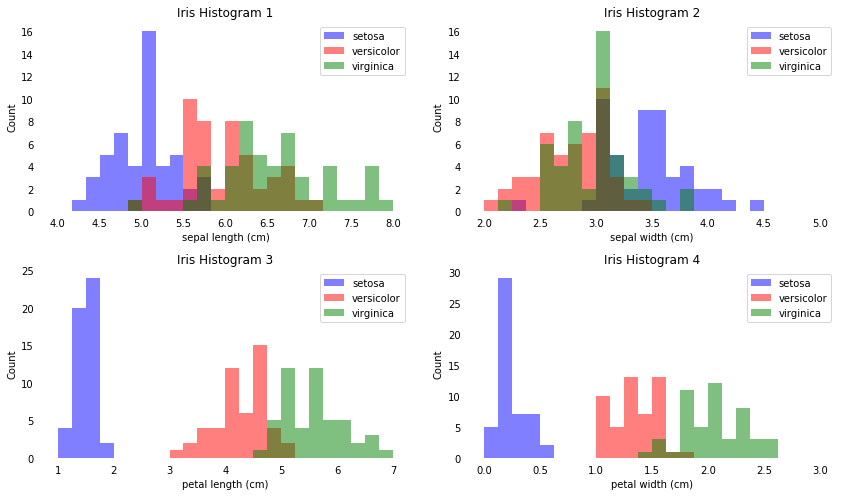

In [21]:
import matplotlib.pyplot as plt
import math

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

for idx, ax in enumerate(axes.ravel()):
    
    # Set bin sizes
    min_b = math.floor(np.min(X[:, idx]))
    max_b = math.ceil(np.max(X[:, idx]))
    bins = np.linspace(min_b, max_b, 25)
    
    # Plotting the histograms
    for label, color in enumerate(('blue', 'red', 'green')):
        ax.hist(X[y==label, idx], color=color, bins=bins,
                label=iris.target_names[label], alpha=0.5)
        
    # Plot annotation
    ax.legend(loc='upper right')
    ax.set_xlabel(iris.feature_names[idx])
    ax.set_ylabel('Count')
    ax.set_title(f'Iris Histogram {idx + 1}')
    
    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom=False, top=False,  
            labelbottom=True, left=False, right=False, labelleft=True)
    
    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False) 
    
fig.tight_layout()
plt.show()

From just looking at these simple graphical representations of the features, we can already tell that the petal lengths and widths are likely better suited as potential features to separate between the three flower classes. In practice, instead of reducing the dimensionality via a projection (here: LDA), a good alternative would be a feature selection technique. For low-dimensional datasets like Iris, a glance at those histograms would already be very informative. Another simple, but very useful technique would be to use feature selection algorithms.

## Normality assumptions

It should be mentioned that LDA assumes normally distributed data, features that are statistically independent and identical covariance matrices for every class. However, this only applies for LDA as classifier, and LDA for dimensionality reduction can also work reasonably well even if those assumptions are violated. And even for classification tasks LDA can be quite robust to the distribution of the data:

_"Linear discriminant analysis frequently achieves good performances in the tasks of face and object recognition, even though the assumptions of common covariance matrix among groups and normality are often violated (Duda, et al., 2001)"_ (Tao Li, et al., 2006)

## LDA in 5 steps

After we went through several preparation steps, our data is finally ready for the actual LDA. In practice, LDA for dimensionality reduction would be just another preprocessing step for a typical machine learning or pattern classification task.

### Step 1: Computing the d-dimensional mean vectors

In this first step, we will start off with a simple computation of the mean vectors $m_i, (i = 0,1,2)$ of the 3 different flower classes:

$$
m_i =
\begin{bmatrix}
\mu_{\omega_i \text{(sepal length)}} \\
\mu_{\omega_i \text{(sepal width)}} \\
\mu_{\omega_i \text{(petal length)}} \\
\mu_{\omega_i \text{(petal width)}}
\end{bmatrix}, \quad
\text{with} \space i = 0,1,2
$$

In [3]:
mean_vectors = np.array([np.mean(X[y==label], axis=0) for label in range(3)])
mean_vectors

array([[5.006, 3.428, 1.462, 0.246],
       [5.936, 2.77 , 4.26 , 1.326],
       [6.588, 2.974, 5.552, 2.026]])

### Step 2: Computing the Scatter Matrices

Now, we will compute the two _4x4_-dimensional matrices: The within-class and the between-class scatter matrix.

#### 2.1 Within-class scatter matrix $S_W$

The __within-class scatter__ matrix $S_W$ is computed by the following equation:

$$S_W = \sum_{i=1}^c S_i$$

where

$S_i = \sum_{x \in D_i}^n (x-m_i)^T (x-m_i)$ (scatter matrix for every class)

and $m_i$ is the mean vector

$m_i = \frac{1}{n_i} \sum_{x \in D_i}^n x_k$

In [4]:
S_W = np.sum([(X[y==label] - mv).T.dot(X[y==label] - mv) for label, mv in enumerate(mean_vectors)], axis=0)
S_W

array([[38.9562, 13.63  , 24.6246,  5.645 ],
       [13.63  , 16.962 ,  8.1208,  4.8084],
       [24.6246,  8.1208, 27.2226,  6.2718],
       [ 5.645 ,  4.8084,  6.2718,  6.1566]])

Alternatively, we could also compute the class-covariance matrices my adding the scaling factor $\frac{1}{N-1}$ to the within-class scatter matrix, so that our equation becomes

$\Sigma_i = \frac{1}{N_i-1} \sum_{x \in D_i}^n (x-m_i)^T (x-m_i)$

and $S_W = \sum_{i=1}^c (N_i-1)\Sigma_i$

where $N_i$ is the sample size of the respective class (here: 50), and in particular case, we can drop the term $(N_i-1)$ since all classes have the same sample size.

However, the resulting eigenspaces will be identical (identical eigenvectors, only the eigenvalues are scaled differently by a constant factor).

### 2.2 Between-class scatter matrix $S_B$

The __between-class scatter__ matrix $S_B$ is computed by the following equation:

$$S_B = \sum_{i=1}^c N_i (m_i - m)^T (m_i - m)$$

where $m$ is the overall mean, and $m_i$ and $N_i$ are the sample mean and sizes of the respective classes.

In [5]:
overall_mean = np.mean(X, axis=0)

S_B = np.sum([len(X[y==label]) * (mv - overall_mean)[:, None].dot((mv - overall_mean)[None, :]) for label, mv in enumerate(mean_vectors)], axis=0)
S_B

array([[ 63.21213333, -19.95266667, 165.2484    ,  71.27933333],
       [-19.95266667,  11.34493333, -57.2396    , -22.93266667],
       [165.2484    , -57.2396    , 437.1028    , 186.774     ],
       [ 71.27933333, -22.93266667, 186.774     ,  80.41333333]])

### Step 3: Solving the generalized eigenvalue problem for the matrix $S_W^{-1}S_B$

Next, we will solve the generalized eigenvalue problem for the matrix $S_W^{-1}S_B$ to obtain the linear discriminants.

In [6]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    print(f'Eigenvector {i+1}:\n{eig_vecs[:, i]}')
    print(f'Eigenvalue {i+1}: {eig_vals[i]}')
    print(40 * '-')

Eigenvector 1:
[-0.20874182 -0.38620369  0.55401172  0.7073504 ]
Eigenvalue 1: 32.191929198278025
----------------------------------------
Eigenvector 2:
[-0.00653196 -0.58661055  0.25256154 -0.76945309]
Eigenvalue 2: 0.28539104262306975
----------------------------------------
Eigenvector 3:
[ 0.87924206 -0.32816889 -0.31374947 -0.1442215 ]
Eigenvalue 3: -1.6067824368826592e-15
----------------------------------------
Eigenvector 4:
[ 0.15169622  0.28172319  0.35490222 -0.87844448]
Eigenvalue 4: -9.195837483528325e-15
----------------------------------------


#### Note

Depending on which version of NumPy and LAPACK we are using, we may obtain the matrix $W$ with its signs flipped. Please note that this is not an issue. If $v$ is an eigenvector of a matrix $\Sigma$, we have

$$\Sigma v = \lambda v$$

Here, $\lambda$ is the eigenvalue, and $v$ is also an eigenvector that has the same eigenvvalue, since

$$\Sigma(-v) = - \Sigma(v) = -\lambda v = \lambda(-v)$$

After this decomposition of our square matrix into eigenvectors and eigenvalues, let us briefly recapitulate how we can interpret those results. As we remember from our first linear algebra class in high school or college, both eigenvectors and eigenvalues are providing us with information about the distortion of a linear transformation: The eigenvectors are basically the direction of this distortion, and the eigenvalues are the scaling factor for the eigenvectors that describes the magnitude of the distortion.

If we are performing the LDA for dimensionality reduction, the eigenvectors are important since they will form the new axes of our new feature subspace. The associated eigenvalues are of particular interest since they will tell us how "informative" the new "axes" are.

Let us briefly double-check our calculation and talk more about the eigenvalues in the next section.

#### Checking the eigenvector-eigenvalue calculation

A quick check that the eigenvector-eigenvalue calculation is correct and satisfy the equation:

$$Av = \lambda v$$

where
-  $A = S_W^{-1} S_B$
-  $v = \text{Eigenvector}$
-  $\lambda = \text{Eigenvalue}$

In [7]:
for i, eigval in enumerate(eig_vals):
    eigvec = eig_vecs[:, i]
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigvec),
                                         eigval * eigvec,
                                         decimal=6, err_msg='', verbose=True)

### Step 4: Selecting linear discriminants for the new feature subspace

#### 4.1. Sorting the eigenvectors by decreasing eigenvalues

Remember from the introduction that we are not only interested in merely projecting the data into a subspace that improves the class separability, but also reduces the dimensionality of our feature space, (where the eigenvectors will form the axes of this new feature subspace).

However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1.

So, in order to decide which eigenvector(s) we want to drop for our lower-dimensional subspace, we have to take a look at the corresponding eigenvalues of the eigenvectors. Roughly speaking, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop.

The common approach is to rank the eigenvectors from highest to lowest corresponding eigenvalue and choose the top $k$ eigenvectors.

In [8]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = list(zip(np.abs(eig_vals), eig_vecs.T))

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for eval, _ in eig_pairs:
    print(eval)

32.191929198278025
0.28539104262306975
9.195837483528325e-15
1.6067824368826592e-15


#### Note

If we take a look at the eigenvalues, we can already see that 2 eigenvalues are close to 0. The reason why these are close to 0 is not that they are not informative but it's due to floating-point imprecision. In fact, these two last eigenvalues should be exactly zero: In LDA, the number of linear discriminants is at most $c-1$ where $c$ is the number of class labels, since the in-between scatter matrix $S_B$ is the sum of $c$ matrices with rank one or less. Note that in the rare case of perfect collinearity (all aligned sample points fall on a straight line), the covariance matrix would have rank one, which would result in only one eigenvector with a nonzero eigenvalue.

Now, let's express the "explained variance" as percentage:

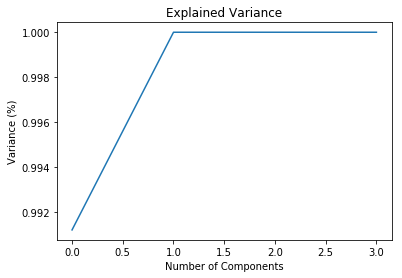

In [9]:
explained_variance_ratio = sorted(eig_vals, reverse=True) / sum(eig_vals)

plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

This plot tells us that just by selecting the first eigenvector we can preserve something around 98.8% or 99% of the total variance of the data. The first eigenvector is by far the most informative one, and we won't lose much information if we would form a 1D-feature space based on this eigenvector.

#### 4.2 Choosing _k_ eigenvectors with the largest eigenvalues

After sorting the eigenpairs by decreasing eigenvalues, it is now time to construct our $k \times d$-dimensional eigenvector matrix $W$ (here $4 \times 2$ based on the 2 most informative eigenpairs) and thereby reducing the initial 4-dimensional feature space into a 2-dimensional feature subspace.

In [10]:
k = 2 # Number of linear discriminants

W = np.array([eig_pair[1] for eig_pair in eig_pairs[:k]]).T
W

array([[-0.20874182, -0.00653196],
       [-0.38620369, -0.58661055],
       [ 0.55401172,  0.25256154],
       [ 0.7073504 , -0.76945309]])

### Step 5: Transforming the samples onto the new subspace

In the last step, we use the $4 \times 2$-dimensional matrix $W$ that we just computed to transform our samples onto the new subspace via the equation

$$Y = X \cdot W$$

where $X$ is the $n \times d$-dimensional matrix representing the $n$ samples, and $Y$ is the transformed $n \times k$-dimensional samples in the new subspace.

In [11]:
X_lda = X.dot(W)
assert X_lda.shape == (150, 2), 'The matrix is not 150x2 dimensional.'

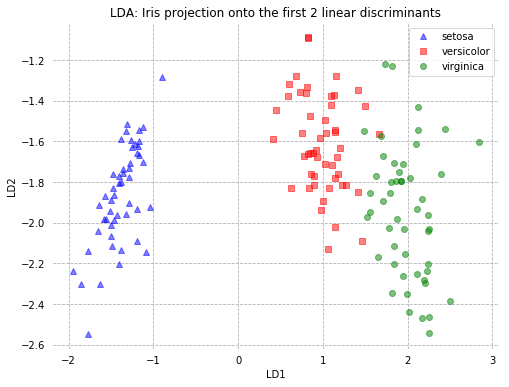

In [12]:
import matplotlib.pyplot as plt

def plot(X, y, target_names, title, xlabel, ylabel):

    color = ('blue', 'red', 'green')
    marker = ('^', 's', 'o')
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    for label in np.unique(y):
        ax.plot(X[y==label, 0], X[y==label, 1], marker[label],
                color=color[label], alpha=0.5, label=target_names[label])

    # plot annotations
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.grid(linestyle='--')

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom=False, top=False,  
            labelbottom=True, left=False, right=False, labelleft=True)

    # remove axis spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.show()
    
plot(X_lda, y, iris.target_names, xlabel='LD1', ylabel='LD2',
     title='LDA: Iris projection onto the first 2 linear discriminants')

The scatter plot above represents our new feature subspace that we constructed via LDA. We can see that the first linear discriminant "LD1" separates the classes quite nicely. However, the second discriminant, "LD2", does not add much valuable information, which we've already concluded when we looked at the ranked eigenvalues in step 4.

## A comparison of PCA and LDA

In order to compare the feature subspace that we obtained via the Linear Discriminant Analysis, we will use the `PCA` class from the `scikit-learn` machine-learning library. The documentation can be found here:

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

For our convenience, we can directly specify to how many components we want to retain in our input dataset via the `n_components` parameter.

In [13]:
from sklearn.decomposition import PCA

sklearn_pca = PCA(n_components=2)

But before we skip to the results of the respective linear transformations, let us quickly recapitulate the purposes of PCA and LDA: PCA finds the axes with maximum variance for the whole data set where LDA tries to find the axes for best class separability.

<img src='files/img/pcavslda.png'>

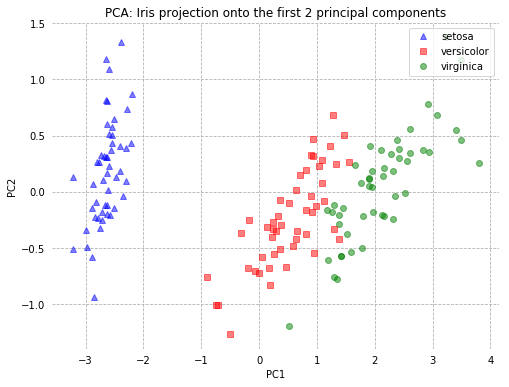

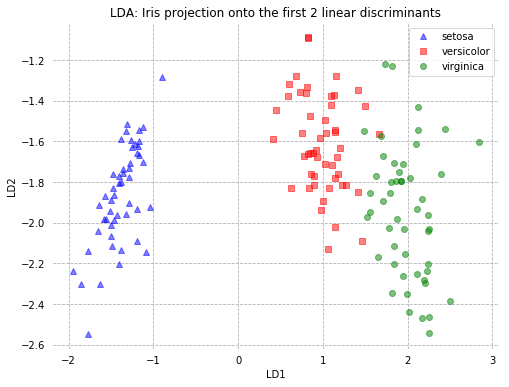

In [14]:
X_pca = sklearn_pca.fit_transform(X)

# sklearn.decomposition.PCA
plot(X_pca, y, iris.target_names, xlabel='PC1', ylabel='PC2',
     title='PCA: Iris projection onto the first 2 principal components')

# Step-by-step LDA
plot(X_lda, y, iris.target_names, xlabel='LD1', ylabel='LD2',
     title='LDA: Iris projection onto the first 2 linear discriminants')

The two plots above nicely confirm what we have discussed before: Where the PCA accounts for the most variance in the whole dataset, the LDA gives us the axes that account for the most variance between the individual classes

## LDA via scikit-learn

Now, after we have seen how a Linear Discriminant Analysis works using a step-by-step approach, there is also a more convenient way to achieve the same via the `LDA` class implemented in the `scikit-learn` machine learning library.

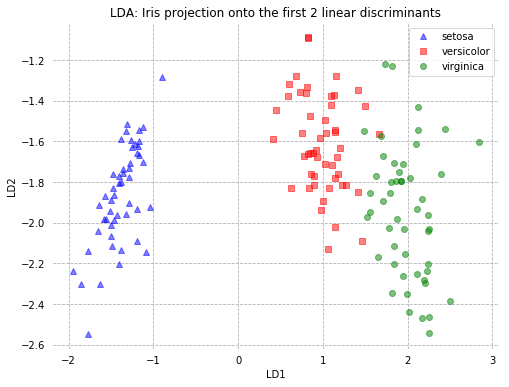

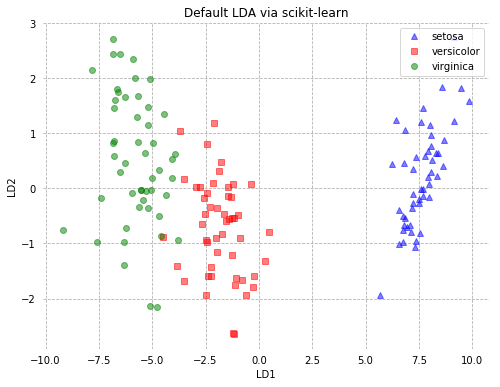

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

# Step-by-step LDA
plot(X_lda, y, iris.target_names, xlabel='LD1', ylabel='LD2',
     title='LDA: Iris projection onto the first 2 linear discriminants')

# LDA via scikit-learn
plot(X_lda_sklearn, y, iris.target_names, xlabel='LD1', ylabel='LD2',
     title='Default LDA via scikit-learn')

The plot above seems to be the exact mirror image of the plot from our step-by-step approach. This is due to the fact that the signs of the eigenvectors can be either positive or negative. To revert the mirror image, we can simply multiply the transformed data by $(-1)$.

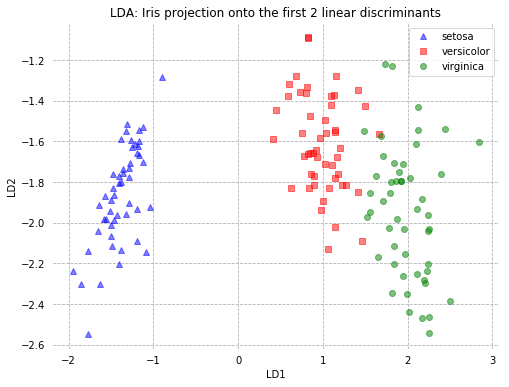

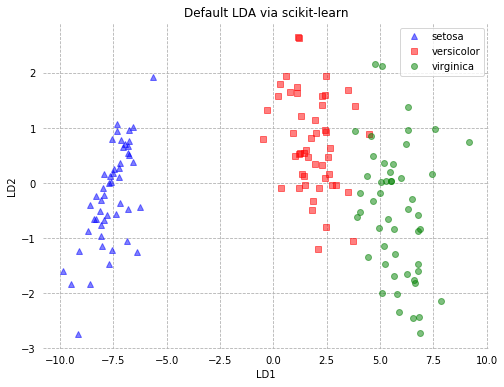

In [16]:
X_lda_sklearn *= -1

# Step-by-step LDA
plot(X_lda, y, iris.target_names, xlabel='LD1', ylabel='LD2',
     title='LDA: Iris projection onto the first 2 linear discriminants')

# LDA via scikit-learn
plot(X_lda_sklearn, y, iris.target_names, xlabel='LD1', ylabel='LD2',
     title='Default LDA via scikit-learn')

## A Note About Standardization

To follow up on a question that I received recently, I wanted to clarify that feature scaling such as standardization does __not__ change the overall results of an LDA and thus may be optional. Yes, the scatter matrices will be different depending on whether the features were scaled or not. In addition, the eigenvectors will be different as well. However, the important part is that the eigenvalues will be exactly the same as well as the final projections - the only difference you'll notice is the scaling of the component axes.

Standardization implies mean centering and scaling to unit variance:

$$x_{std} = \frac{x - \mu_x}{\sigma_x}$$

After standardization, the columns will have zero mean ($\mu_{x_{std}} = 0$) and a standard deviation of 1 ($\sigma_{x_{std}} = 1$).

In [17]:
X_std = (X - X.mean(axis=0)) / X.std(axis=0)

Below, I simply copied the individual steps of an LDA, which we discussed previously, into a Python class for convenience.

In [18]:
class MyLDA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        
    def fit_transform(self, X, y):
        
        self.X = X
        self.y = y
        
        if self.n_components is None:
            self.n_components = X.shape[1]
        
        # Computing the d-dimensional mean vectors
        self.mean_vectors = np.array([np.mean(X[y==label], axis=0) for label in range(3)])
        
        # Computing the overall mean
        self.overall_mean = np.mean(X, axis=0)
        
        # Within-class scatter matrix
        self.S_W = np.sum([(X[y==label] - mv).T.dot(X[y==label] - mv) for label, mv in enumerate(self.mean_vectors)], axis=0)
        
        # Between-class scatter matrix
        self.S_B = np.sum([len(X[y==label]) * (mv - self.overall_mean)[:, None].dot((mv - self.overall_mean)[None, :]) for label, mv in enumerate(self.mean_vectors)], axis=0)
        
        # Obtain linear discriminants
        self.eig_vals, self.eig_vecs = np.linalg.eig(np.linalg.inv(self.S_W).dot(self.S_B))
        
        # Calculating the explained variance
        self.explained_variance_ratio = sorted(self.eig_vals, reverse=True) / sum(self.eig_vals)
        
        # Make a sorted list of (eigenvalue, eigenvector) tuples
        eig_pairs = sorted(list(zip(np.abs(self.eig_vals), self.eig_vecs.T)), key=lambda x: x[0], reverse=True)

        # Choosing k eigenvectors with the largest eigenvalues
        self.W = np.array([eig_pair[1] for eig_pair in eig_pairs[:self.n_components]]).T
        
        # Transforming the samples onto the new subspace
        self.X_transformed = (self.X).dot(self.W)
        
        return self.X_transformed

First, we are going to print the eigenvalues, eigenvectors, transformation matrix of the un-scaled data:

Eigenvalues: [ 3.21919292e+01  2.85391043e-01 -1.60678244e-15 -9.19583748e-15]

Eigenvectors:
[[-0.20874182 -0.00653196  0.87924206  0.15169622]
 [-0.38620369 -0.58661055 -0.32816889  0.28172319]
 [ 0.55401172  0.25256154 -0.31374947  0.35490222]
 [ 0.7073504  -0.76945309 -0.1442215  -0.87844448]]

W:
[[-0.20874182 -0.00653196]
 [-0.38620369 -0.58661055]
 [ 0.55401172  0.25256154]
 [ 0.7073504  -0.76945309]]


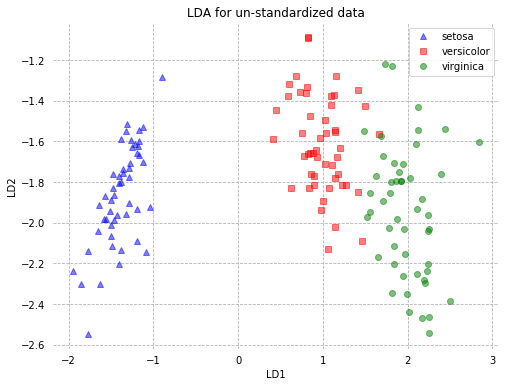

In [19]:
my_lda = MyLDA(n_components=2)
X_lda = my_lda.fit_transform(X, y)

eig_vals = my_lda.eig_vals
eig_vecs = my_lda.eig_vecs
W = my_lda.W

print(f'Eigenvalues: {eig_vals}\n')
print(f'Eigenvectors:\n{eig_vecs}\n')
print(f'W:\n{W}')

plot(X_lda, y, iris.target_names, xlabel='LD1', ylabel='LD2',
     title='LDA for un-standardized data')

Next, we are repeating this process for the standardized dataset:

Eigenvalues: [ 3.21919292e+01  2.85391043e-01  2.91720136e-15 -9.34758600e-16]

Eigenvectors:
[[ 0.15128777  0.00693578  0.59309634 -0.39628002]
 [ 0.14733266  0.32786115 -0.1798846  -0.0836506 ]
 [-0.85598541 -0.57170517 -0.76143218 -0.48931245]
 [-0.47190474  0.75207191  0.18999816  0.77235876]]

W:
[[ 0.15128777  0.00693578]
 [ 0.14733266  0.32786115]
 [-0.85598541 -0.57170517]
 [-0.47190474  0.75207191]]


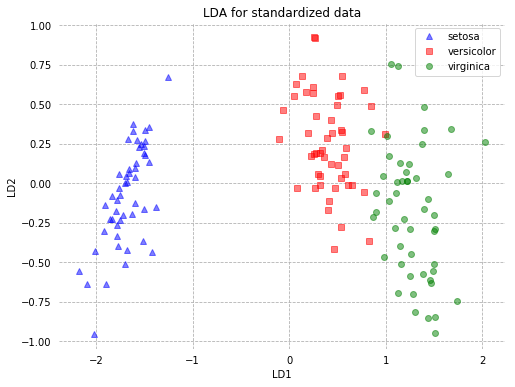

In [20]:
my_lda_std = MyLDA(n_components=2)
X_lda_std = my_lda_std.fit_transform(X_std, y) * (-1)

eig_vals_std = my_lda_std.eig_vals
eig_vecs_std = my_lda_std.eig_vecs
W_std = my_lda_std.W

print(f'Eigenvalues: {eig_vals_std}\n')
print(f'Eigenvectors:\n{eig_vecs_std}\n')
print(f'W:\n{W_std}')

plot(X_lda_std, y, iris.target_names, xlabel='LD1', ylabel='LD2',
     title='LDA for standardized data')

As we can see, the eigenvalues are exactly the same whether we scaled our data or not (note that since $W$ has a rank of 2, the two lowest eigenvalues in this 4-dimensional dataset should effectively be 0). Furthermore, we see that the projections look identical except for the different scaling of the component axes.